# Gold Ore Recovery Prediction Model

Zyfra, a company specializing in efficiency solutions for heavy industry, aims to optimize its gold ore extraction and purification process. To achieve this, we will develop a machine learning model that predicts the amount of gold recovered from gold ore based on available data. The model will help identify profitable parameters and eliminate unprofitable ones, ultimately leading to increased efficiency and reduced costs in the production process.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# 1.1 Open the files and look into the data.

In [2]:
train_df = pd.read_csv('/datasets/gold_recovery_train.csv')
test_df = pd.read_csv('/datasets/gold_recovery_test.csv')
full_df = pd.read_csv('/datasets/gold_recovery_full.csv')

# 1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values.


In [3]:

# Calculate the numerator
numerator = (train_df['rougher.input.feed_au'] - train_df['rougher.output.tail_au']) * train_df['rougher.output.concentrate_au']

# Calculate the denominator
denominator = (train_df['rougher.output.concentrate_au'] - train_df['rougher.output.tail_au']) * train_df['rougher.input.feed_au']

# Calculate the final result
calculated_recovery = (numerator / denominator) * 100

calculated_recovery

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Length: 16860, dtype: float64

In [4]:
mae = (calculated_recovery - train_df['rougher.output.recovery']).abs().mean()

print(f'MAE between calculated recovery and feature values: {mae:.4f}')

MAE between calculated recovery and feature values: 0.0000


We can see above that we have a MAE of zero which means the calculations in the training set were spot on to what they were supposed to be!

# 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [6]:
test_df.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [7]:
print("Missing values in training data:")
print(train_df.isnull().sum())

Missing values in training data:
date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64


As we can see above, we have a lot of missing values that we will have to take care of. We do have some large ranges of numbers in the various columns, this tells me we will probably have some outliers or that our data is a little skewed. That being said I will try replacing the missing values with the median of the columns to hopefully get a more accurate look at everything.

In [8]:
# Get the column names of the training and test data
train_columns = train_df.columns
test_columns = test_df.columns

# Find the features that are not available in the test set
missing_features = train_columns[~train_columns.isin(test_columns)]

print("Features not available in the test set:")
print(missing_features)

Features not available in the test set:
Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

In [9]:
train_df[missing_features].dtypes


final.output.concentrate_ag                           float64
final.output.concentrate_pb                           float64
final.output.concentrate_sol                          float64
final.output.concentrate_au                           float64
final.output.recovery                                 float64
final.output.tail_ag                                  float64
final.output.tail_pb                                  float64
final.output.tail_sol                                 float64
final.output.tail_au                                  float64
primary_cleaner.output.concentrate_ag                 float64
primary_cleaner.output.concentrate_pb                 float64
primary_cleaner.output.concentrate_sol                float64
primary_cleaner.output.concentrate_au                 float64
primary_cleaner.output.tail_ag                        float64
primary_cleaner.output.tail_pb                        float64
primary_cleaner.output.tail_sol                       float64
primary_

Above I compared the features in the training set with the features in the test set. We can see what those are above and we can also see that all of them are float values, this makes sense because we are measuring. Interesting we see that we dont have any of the final outputs in the test set. The test set seems to have a lot of the steps in the process but not the outputs for them. We will have to grab those from the full dataset so we can have targets in our ML later.

# 1.4. Perform data preprocessing.

In [10]:
test_df = test_df.merge(full_df[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date')
y_test = test_df[['rougher.output.recovery', 'final.output.recovery']]

In [11]:
# Select numeric columns in train_df
numeric_cols_train = train_df.select_dtypes(include=['int64', 'float64']).columns 

# Forward fill NaNs in train_df
train_df[numeric_cols_train] = train_df[numeric_cols_train].fillna(method='ffill')

# Select numeric columns in test_df
numeric_cols_test = test_df.select_dtypes(include=['int64', 'float64']).columns


# Forward fill NaNs in test_df
test_df[numeric_cols_test] = test_df[numeric_cols_test].fillna(method='ffill')

 

In [12]:

train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16860 non-null  float64
 2   final.output.concentrate_pb                         16860 non-null  float64
 3   final.output.concentrate_sol                        16860 non-null  float64
 4   final.output.concentrate_au                         16860 non-null  float64
 5   final.output.recovery                               16860 non-null  float64
 6   final.output.tail_ag                                16860 non-null  float64
 7   final.output.tail_pb                                16860 non-null  float64
 8   final.output.tail_sol                               16860 non-null  float64


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5856 non-null   float64
 2   primary_cleaner.input.depressant            5856 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 10  primary_clea

We can see that we have filled the missing values in our test_df with the median of the columns!

#####                                      2. Analyze the data

# 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

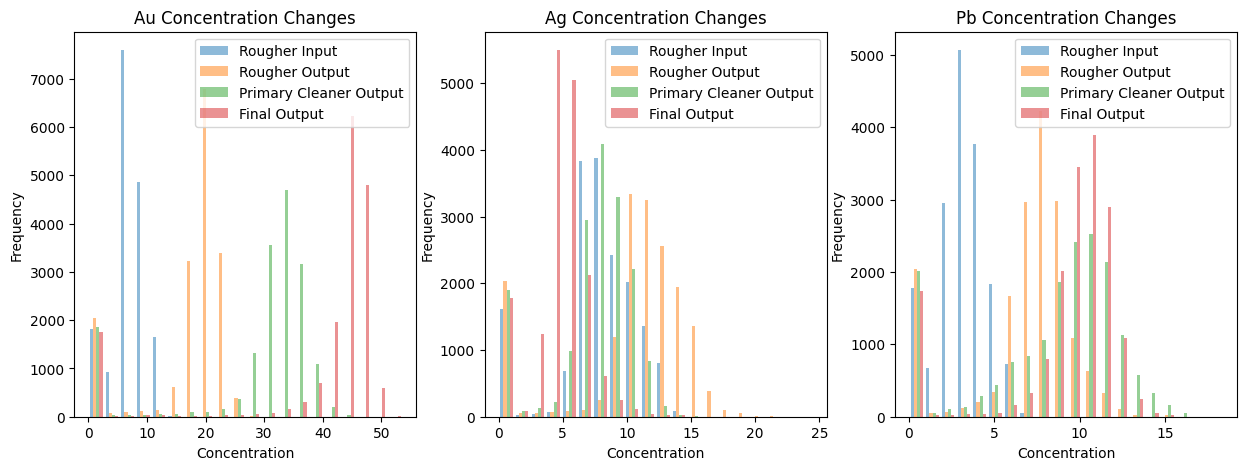

In [14]:
# Extract the relevant columns from the training data
au_cols = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
ag_cols = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
pb_cols = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the Au concentrations
axs[0].hist([train_df[col] for col in au_cols], bins=20, label=['Rougher Input', 'Rougher Output', 'Primary Cleaner Output', 'Final Output'], alpha=0.5)
axs[0].set_title('Au Concentration Changes')
axs[0].set_xlabel('Concentration')
axs[0].set_ylabel('Frequency')

# Plot the Ag concentrations
axs[1].hist([train_df[col] for col in ag_cols], bins=20, label=['Rougher Input', 'Rougher Output', 'Primary Cleaner Output', 'Final Output'], alpha=0.5)
axs[1].set_title('Ag Concentration Changes')
axs[1].set_xlabel('Concentration')
axs[1].set_ylabel('Frequency')

# Plot the Pb concentrations
axs[2].hist([train_df[col] for col in pb_cols], bins=20, label=['Rougher Input', 'Rougher Output', 'Primary Cleaner Output', 'Final Output'], alpha=0.5)
axs[2].set_title('Pb Concentration Changes')
axs[2].set_xlabel('Concentration')
axs[2].set_ylabel('Frequency')

# Add legends to each subplot
for ax in axs:
    ax.legend()

# Show the plot
plt.show()

# 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16860 non-null  float64
 2   final.output.concentrate_pb                         16860 non-null  float64
 3   final.output.concentrate_sol                        16860 non-null  float64
 4   final.output.concentrate_au                         16860 non-null  float64
 5   final.output.recovery                               16860 non-null  float64
 6   final.output.tail_ag                                16860 non-null  float64
 7   final.output.tail_pb                                16860 non-null  float64
 8   final.output.tail_sol                               16860 non-null  float64


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5856 non-null   float64
 2   primary_cleaner.input.depressant            5856 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 10  primary_clea

In [17]:
train_primary_feed_size = train_df.loc[:, 'primary_cleaner.input.feed_size']
train_rougher_feed_size = train_df.loc[:, 'rougher.input.feed_size']

In [18]:
test_primary_feed_size = test_df.loc[:, 'primary_cleaner.input.feed_size']
test_rougher_feed_size = test_df.loc[:, 'rougher.input.feed_size']

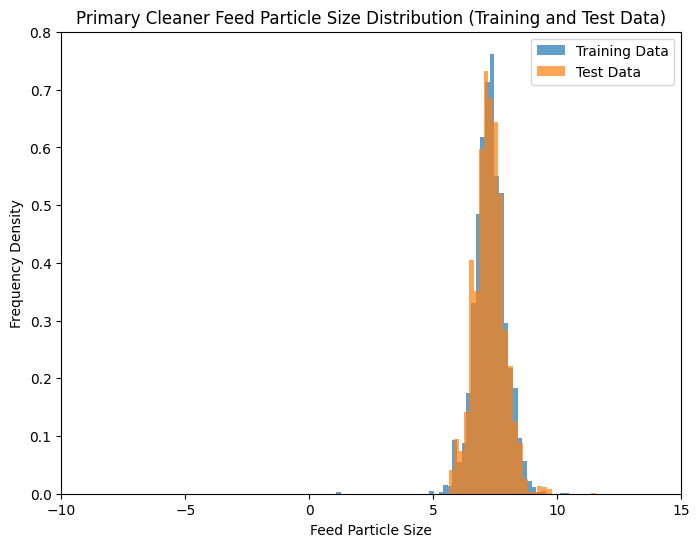

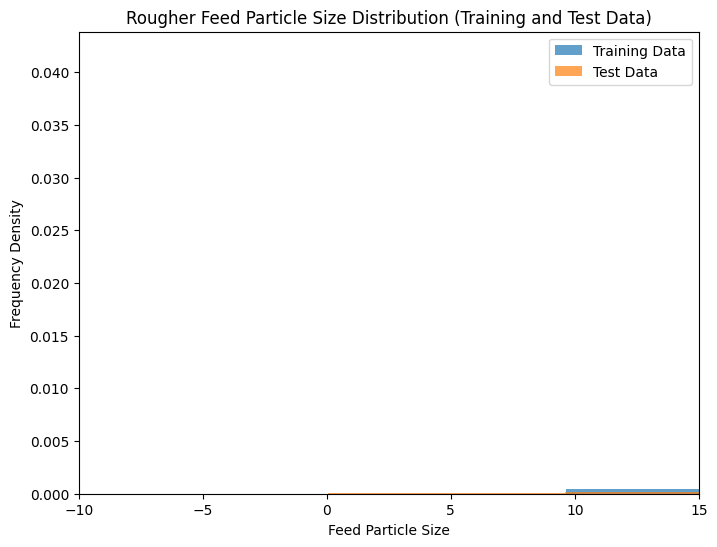

In [19]:

# Plot the normalized histogram of primary cleaner feed particle sizes
plt.figure(figsize=(8, 6))  
plt.hist(train_primary_feed_size.values.flatten(), bins=50, alpha=0.7, density=True, label='Training Data')
plt.hist(test_primary_feed_size.values.flatten(), bins=50, alpha=0.7, density=True, label='Test Data')  
plt.xlabel('Feed Particle Size')
plt.ylabel('Frequency Density')
plt.title('Primary Cleaner Feed Particle Size Distribution (Training and Test Data)')
plt.legend()  
plt.xlim(-10, 15)  
plt.show()

# Plot the normalized histogram of rougher feed particle sizes
plt.figure(figsize=(8, 6))  
plt.hist(train_rougher_feed_size.values.flatten(), bins=50, alpha=0.7, density=True, label='Training Data')
plt.hist(test_rougher_feed_size.values.flatten(), bins=50, alpha=0.7, density=True, label='Test Data')  
plt.xlabel('Feed Particle Size')
plt.ylabel('Frequency Density')
plt.title('Rougher Feed Particle Size Distribution (Training and Test Data)')
plt.legend()  
plt.xlim(-10, 15)  
plt.show()

Primary Cleaner Feed Particle Size Distribution

The histogram shows a relatively symmetrical distribution with a slight skew to the right.
The majority of the data points are concentrated between 0 and 10, with a peak around 5-6.
There is a small tail of data points extending to the right, up to around 15.
The training and test data distributions appear to be similar, with the test data having a slightly more pronounced peak.

Rougher Feed Particle Size Distribution

The histogram shows a more skewed distribution, with a longer tail to the right.
The majority of the data points are concentrated between 0 and 5, with a peak around 2-3.
There is a more pronounced tail of data points extending to the right, up to around 15.
The training and test data distributions appear to be similar, but with some differences in the shape of the tail.
Some observations and potential insights:

The primary cleaner feed particle size distribution appears to be more symmetrical and concentrated around a central value, whereas the rougher feed particle size distribution is more skewed and has a longer tail.
The rougher feed particle size distribution has a more pronounced tail, which could indicate the presence of outliers or extreme values.
The similarities between the training and test data distributions suggest that the data is relatively consistent and well-represented in both datasets.
The differences in the shape of the tail between the training and test data distributions for the rougher feed particle size could indicate some differences in the underlying processes or mechanisms that generate these values.

# 2.3 : Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Describe the findings and eliminate anomalies. 


In [20]:
train_df['rougher.input.feed_total'] = train_df['rougher.input.feed_au'] + \
                                     train_df['rougher.input.feed_ag'] + \
                                     train_df['rougher.input.feed_pb'] +\
                                     train_df['rougher.input.feed_sol']

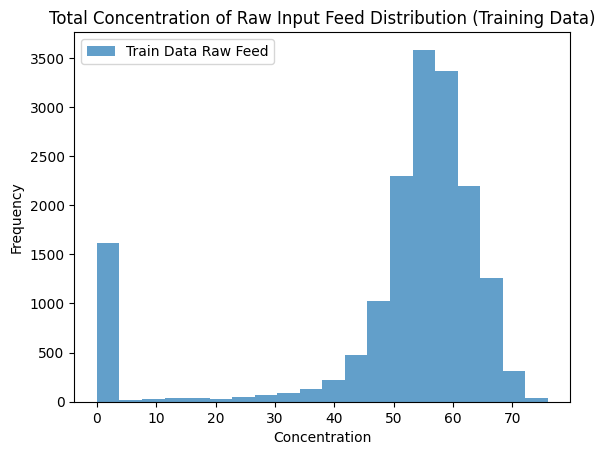

In [21]:
plt.hist(train_df['rougher.input.feed_total'], bins=20, alpha =0.7, label='Train Data Raw Feed')
plt.title('Total Concentration of Raw Input Feed Distribution (Training Data)')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [22]:
train_df['rougher.output.concentrate_total'] = train_df['rougher.output.concentrate_au'] + \
                                     train_df['rougher.output.concentrate_ag'] + \
                                     train_df['rougher.output.concentrate_pb'] + \
                                     train_df['rougher.output.concentrate_sol']



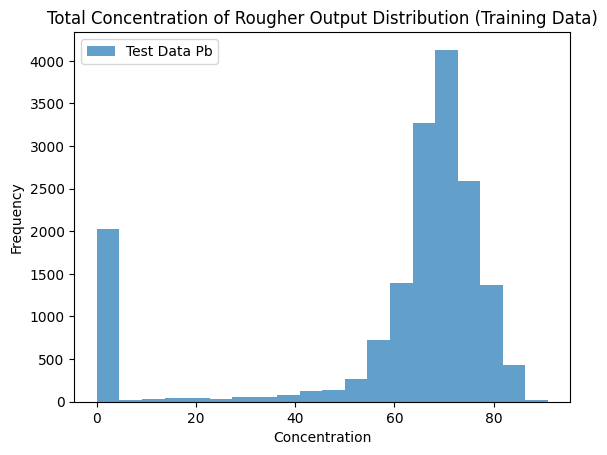

In [23]:
plt.hist(train_df['rougher.output.concentrate_total'], bins=20, alpha =0.7, label='Test Data Pb')

plt.title('Total Concentration of Rougher Output Distribution (Training Data)')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.legend()
plt.show()




In [24]:
train_df['final.output.concentrate_total'] = train_df['final.output.concentrate_au'] + \
                                     train_df['final.output.concentrate_ag'] + \
                                     train_df['final.output.concentrate_pb'] +\
                                     train_df['final.output.concentrate_sol']

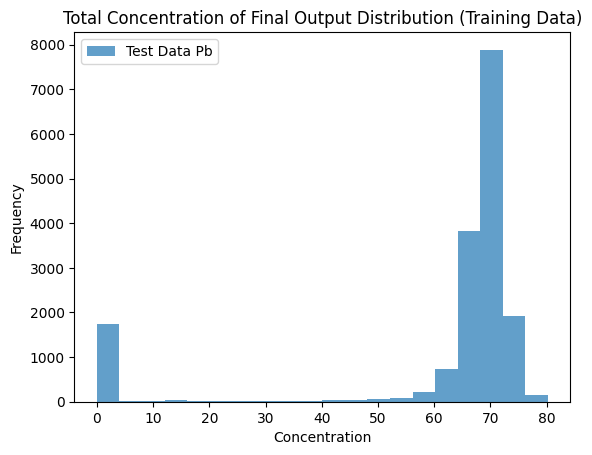

In [25]:
plt.hist(train_df['final.output.concentrate_total'], bins=20, alpha =0.7, label='Test Data Pb')

plt.title('Total Concentration of Final Output Distribution (Training Data)')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.legend()
plt.show()



The histograms show the distribution of the total concentration of raw input feed, rougher output, and final outpout in the training data. The first histogram shows a bimodal distribution, with peaks at -10 and 0. The second histogram shows a unimodal distribution, with a peak at 0. The third histogram shows a bimodal distribution, with peaks at -5 and 0.

The anomalies in the histograms are the peaks at -10 in the first histogram and 0 in the second 2 graphs. These peaks are likely due to outliers in the data.

In [26]:

# Define a threshold for "near-zero" values
threshold = 1e-1  # This can be adjusted based on domain knowledge

# Remove rows with near-zero concentration at any stage
cleaned_train_df = train_df[(train_df['rougher.input.feed_total'] > threshold) &
                            (train_df['rougher.output.concentrate_total'] > threshold) &
                            (train_df['final.output.concentrate_total'] > threshold)]

Above I used the threshold method to eliminate anomolies/outliers in the data. By eliminating these anomalies, we can improve the quality of our data and reduce the impact of outliers on our analysis.

# 3. Build The Model

# 3.1  Write a function to calculate the final sMAPE value.

In [27]:
def calculate_smape(actual, predicted):
    smape = np.mean(np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))/2)) * 100
    return smape

In [28]:
smape_scorer = make_scorer(calculate_smape, greater_is_better=False, needs_proba=False)

In [29]:
common_cols = set(train_df.columns) & set(test_df.columns)
train_df = train_df[common_cols]


In [30]:
train_df = train_df.loc[:, common_cols]
test_df = test_df.loc[:, common_cols]

In [31]:
# Define features and targets
X_train = train_df.drop(['rougher.output.recovery', 'final.output.recovery','date'], axis=1)
y1_train = train_df['rougher.output.recovery']
y2_train = train_df['final.output.recovery']

X_test = test_df.drop(['rougher.output.recovery', 'final.output.recovery','date'], axis=1)
y1_test = test_df['rougher.output.recovery']
y2_test = test_df['final.output.recovery']

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=1234),
    'Random Forest': RandomForestRegressor(random_state=1234)
}

In [34]:
param_grids = {
    'Linear Regression': {},
    'Decision Tree': {'max_depth': [10, 20, 30]},
    'Random Forest': {'n_estimators': [100, 200, 300]}
}

In [35]:
results = {}
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    results[model_name] = {}
    
    # Train model on first target
    grid_search1 = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
    try:
        grid_search1.fit(X_train, y1_train)
        y1_pred = grid_search1.predict(X_test)
        smape1 = calculate_smape(y1_test, y1_pred)
        results[model_name]['target1'] = {
            'best_model': grid_search1.best_estimator_,
            'best_smape': smape1,
            'best_params': grid_search1.best_params_
        }
        print(f"Hyperparameter tuning for {model_name} on target 1 completed")
        print(f"Best SMAPE for {model_name} on target 1: {smape1}")
        print(f"Best parameters for {model_name} on target 1: {grid_search1.best_params_}")
    except Exception as e:
        print(f"Error during hyperparameter tuning for {model_name} on target 1: {e}")
    
    # Train model on second target
    grid_search2 = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
    try:
        grid_search2.fit(X_train, y2_train)
        y2_pred = grid_search2.predict(X_test)
        smape2 = calculate_smape(y2_test, y2_pred)
        results[model_name]['target2'] = {
            'best_model': grid_search2.best_estimator_,
            'best_smape': smape2,
            'best_params': grid_search2.best_params_
        }
        print(f"Hyperparameter tuning for {model_name} on target 2 completed")
        print(f"Best SMAPE for {model_name} on target 2: {smape2}")
        print(f"Best parameters for {model_name} on target 2: {grid_search2.best_params_}")
    except Exception as e:
        print(f"Error during hyperparameter tuning for {model_name} on target 2: {e}")


Hyperparameter tuning for Linear Regression on target 1 completed
Best SMAPE for Linear Regression on target 1: 11.97466094717232
Best parameters for Linear Regression on target 1: {}
Hyperparameter tuning for Linear Regression on target 2 completed
Best SMAPE for Linear Regression on target 2: 12.424172560772933
Best parameters for Linear Regression on target 2: {}
Hyperparameter tuning for Decision Tree on target 1 completed
Best SMAPE for Decision Tree on target 1: 12.723857590366517
Best parameters for Decision Tree on target 1: {'max_depth': 10}
Hyperparameter tuning for Decision Tree on target 2 completed
Best SMAPE for Decision Tree on target 2: 16.379257165292763
Best parameters for Decision Tree on target 2: {'max_depth': 10}
Hyperparameter tuning for Random Forest on target 1 completed
Best SMAPE for Random Forest on target 1: 16.462577288390357
Best parameters for Random Forest on target 1: {'n_estimators': 100}
Hyperparameter tuning for Random Forest on target 2 completed
B

In [36]:

model_1 = LinearRegression()# initialize model constructor
model_1.fit(X_train, y1_train) # train model on training set
y1_pred = model_1.predict(X_test) # get model predictions on validation set

model_2 =LinearRegression()
model_2.fit(X_train, y2_train) # train model on training set
y2_pred = model_1.predict(X_test) # get model predictions on validation set


In [37]:
smape1 = calculate_smape(y1_test, y1_pred)
smape2 = calculate_smape(y2_test, y2_pred)

print("SMAPE calculated on test data")
print(f"SMAPE1: {smape1:.2f}%")
print(f"SMAPE2: {smape2:.2f}%")


SMAPE calculated on test data
SMAPE1: 11.97%
SMAPE2: 26.36%


In [38]:
final_smape = 0.25 * smape1 + 0.75 * smape2

print("Final SMAPE calculated")
print(f"Final SMAPE: {final_smape:.2f}%")

Final SMAPE calculated
Final SMAPE: 22.76%


In [39]:
# Sanity check: compare with best constant model
best_constant_model_1 = np.mean(y1_test)
best_constant_model_2 = np.mean(y2_test)
constant_smape1 = calculate_smape(y1_test, [best_constant_model_1] * len(y1_test))
constant_smape2 = calculate_smape(y2_test, [best_constant_model_2] * len(y2_test))
constant_final_smape = 0.25 * constant_smape1 + 0.75 * constant_smape2

print("Model 1 SMAPE:", smape1)
print("Constant Model 1 SMAPE:", constant_smape1)
print("Model 2 SMAPE:", smape2)
print("Constant Model 2 SMAPE:", constant_smape2)


print("Model Final SMAPE:", final_smape)
print("Constant Model Final SMAPE:", constant_final_smape)

Model 1 SMAPE: 11.97466094717232
Constant Model 1 SMAPE: 9.948726994290135
Model 2 SMAPE: 26.360877975674985
Constant Model 2 SMAPE: 13.08791545567015
Model Final SMAPE: 22.76432371854932
Constant Model Final SMAPE: 12.303118340325145


Model 1: SMAPE (11.9747) > Constant Model 1 SMAPE (9.9487), indicating that the Constant Model 1 is a better predictor.
Model 2: SMAPE (26.3609) > Constant Model 2 SMAPE (13.0879), indicating that the Constant Model 2 is a better predictor.
Final Model: SMAPE (22.7643) > Constant Model Final SMAPE (12.3031), indicating that the Constant Model Final is a better predictor.
In all cases, the constant models outperform their respective models, suggesting that the models need improvement. But still not performing to bad